In [1]:
from fastai.tabular.all import *
from fastcore.utils import *
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

df_nn = pd.read_csv('dataset/train.csv', low_memory=False)
df_nn_final = df_nn.drop('id', axis=1)

"""
Categorical embedding
"""

cont,cat = cont_cat_split(df_nn_final, max_card=9000, dep_var='target')
procs_nn = [Categorify, Normalize]
splits = RandomSplitter(seed=23)(df_nn_final)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

to_nn = TabularPandas(df_nn, procs_nn, cat, cont,
                      splits=splits, y_names='target')
dls = to_nn.dataloaders(1024, device = device)

learn = tabular_learner(dls, layers=[500,250], n_out=1)
learn.fit_one_cycle(8, 5e-4)

preds,targs = learn.get_preds()
roc_auc_score(targs, preds)

learn.save('learn8')

# Machine Learning Models
df = pd.read_csv('dataset/train.csv', low_memory=False)

# using the neural net's `cat`, `cont`, and `splits`
procs = [Categorify]
to = TabularPandas(df, procs, cat, cont, 'target', splits = splits)

def rf(xs, y, n_estimators=40, max_samples=130_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf).fit(xs, y)

def auc(m, xs, y):
    preds = m.predict(xs)
    return round(roc_auc_score(y, preds), 3)

# Replacing Nominal variables with Embeddings
learn = learn.load('learn8')

def embed_features(learner, xs):
    """
    learner: fastai Learner used to train the neural net
    xs: DataFrame containing input variables with nominal values defined by their rank.
    ::returns:: a copy of `xs` with embeddings replacing each categorical variable
    """
    xs = xs.copy()
    for i,col in enumerate(learn.dls.cat_names):
        emb = learn.model.embeds[i]
        emb_data = emb(tensor(xs[col], dtype=torch.int64).to(device))
        emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]
        feat_df = pd.DataFrame(data=emb_data, index=xs.index, columns=emb_names)
        xs = xs.drop(col, axis=1)
        xs = xs.join(feat_df)
        return xs
    
emb_xs = embed_features(learn, to.train.xs)
emb_valid_xs = embed_features(learn, to.valid.xs)
emb_valid_xs

epoch,train_loss,valid_loss,time
0,0.147625,0.127299,00:20
1,0.119825,0.120103,00:17
2,0.115187,0.115715,00:18
3,0.112697,0.114050,00:17
4,0.110247,0.114410,00:17
5,0.108850,0.111411,00:18
6,0.107260,0.110701,00:17
7,0.106059,0.110447,00:18


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cat0_0,cat0_1,cat0_2
277491,6,4,2,7,34,1,31,60,1,148,...,0.292775,0.210421,0.335680,0.508110,0.375804,0.485737,0.388535,0.055274,0.037739,0.052517
59826,11,1,1,13,34,3,20,4,13,258,...,0.717059,0.555945,0.253756,0.810781,0.558822,0.821682,0.950494,0.055274,0.037739,0.052517
100532,6,10,1,5,34,3,1,36,1,76,...,0.300573,0.807069,0.559432,0.310892,0.414348,0.328559,0.198210,-0.057808,-0.070822,-0.051652
127444,8,13,1,6,3,1,9,60,1,148,...,0.260020,0.762579,0.929469,0.368868,0.400274,0.582639,0.436348,0.055274,0.037739,0.052517
268466,13,1,2,5,34,1,9,52,5,160,...,0.292645,0.487171,0.581556,0.332349,0.366024,0.374952,0.382322,-0.057808,-0.070822,-0.051652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292950,8,13,1,6,3,5,47,51,1,175,...,0.310330,0.354413,0.335381,0.433126,0.758386,0.438863,0.488459,0.055274,0.037739,0.052517
235306,6,3,1,5,34,3,20,11,1,55,...,0.731341,0.734535,0.548252,0.304629,0.338420,0.321991,0.339444,-0.057808,-0.070822,-0.051652
187628,15,3,1,6,34,1,37,34,1,148,...,0.278301,0.735457,0.787859,0.313780,0.700493,0.799430,0.464530,0.055274,0.037739,0.052517
200243,6,1,2,5,3,1,10,47,5,175,...,0.247176,0.052474,0.172384,0.552959,0.405473,0.266106,0.531018,0.055274,0.037739,0.052517


In [2]:
df

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499993,A,N,F,A,E,BU,A,AS,K,...,0.662428,0.671927,0.390566,0.145840,0.262767,0.514248,0.519340,0.617436,0.688007,0
299996,499995,A,K,A,A,G,BI,A,K,AE,...,0.821657,0.620356,0.384891,0.735879,0.547731,0.726653,0.470575,0.275743,0.638939,0
299997,499996,A,G,M,A,H,BI,C,L,F,...,0.407037,0.232436,0.832482,0.810663,0.596939,0.308821,0.373997,0.518024,0.452144,1
299998,499997,B,H,A,D,B,BI,A,AA,AX,...,0.808045,0.630708,0.346898,0.735147,0.563488,0.609836,0.680430,0.318453,0.335822,0


Net(
  (fc1): Linear(in_features=32, out_features=10, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)


100%|█████████████████████████████████████████████| 4/4 [00:11<00:00,  2.88s/it]


ConversionError: Failed to convert value(s) to axis units: array(['A', 'A', 'A', ..., 'A', 'B', 'A'], dtype=object)

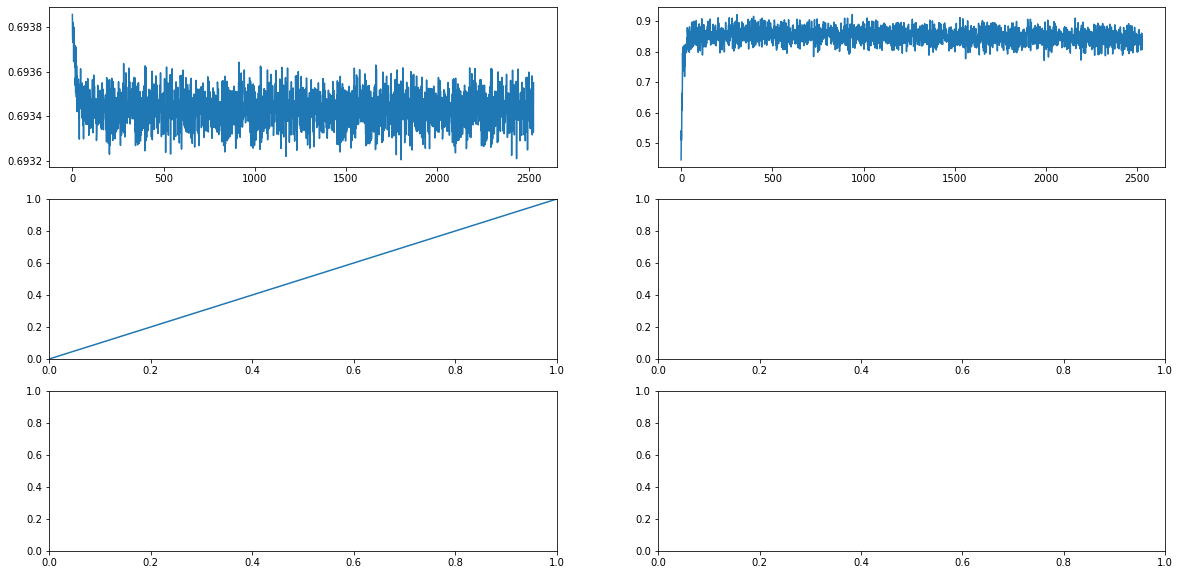

In [3]:
from torch.utils.data import Dataset
from sklearn.cluster import KMeans

import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as opt

from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from utils import *

train_loader, valid_loader = pandas_to_tensor(df, emb_xs, emb_valid_xs)

nb_clust=1

# -1 cause we remove the target
net = Net(df.shape[1], nb_clust)
print(net)

max_epochs = 4
#loss_fct = nn.CrossEntropyLoss()
loss_fct = nn.BCEWithLogitsLoss()
l_loss = list()
l_loss_test = list()
l_roc_train = list()
l_roc_test = list()

optim = opt.Adam(net.parameters(), lr=0.01)


for epoch in tqdm(range(max_epochs)):
    t0 = datetime.now()
    net.train()
    for batch, (x, y) in enumerate(train_loader):
        
        optim.zero_grad()
        
        # Predict soft-targets and embeddings
        proba, output = net(x)
        
        loss = loss_fct(proba, y)
        loss.backward()
        
        optim.step()
        
        l_loss.append(loss.item())
        l_roc_train.append(roc_auc_score(y.detach().numpy(), proba.detach().numpy()))
        
with torch.no_grad():
    for batch, (x, y) in enumerate(valid_loader):
        proba, output = net(x)

        loss = loss_fct(proba, y)
        l_loss_test.append(loss)
        
        l_roc_test.append(roc_auc_score(y.detach().numpy(), proba.detach().numpy()))
        
print_scores(l_loss, l_roc_train, _, _, l_roc_test, l_loss_test)

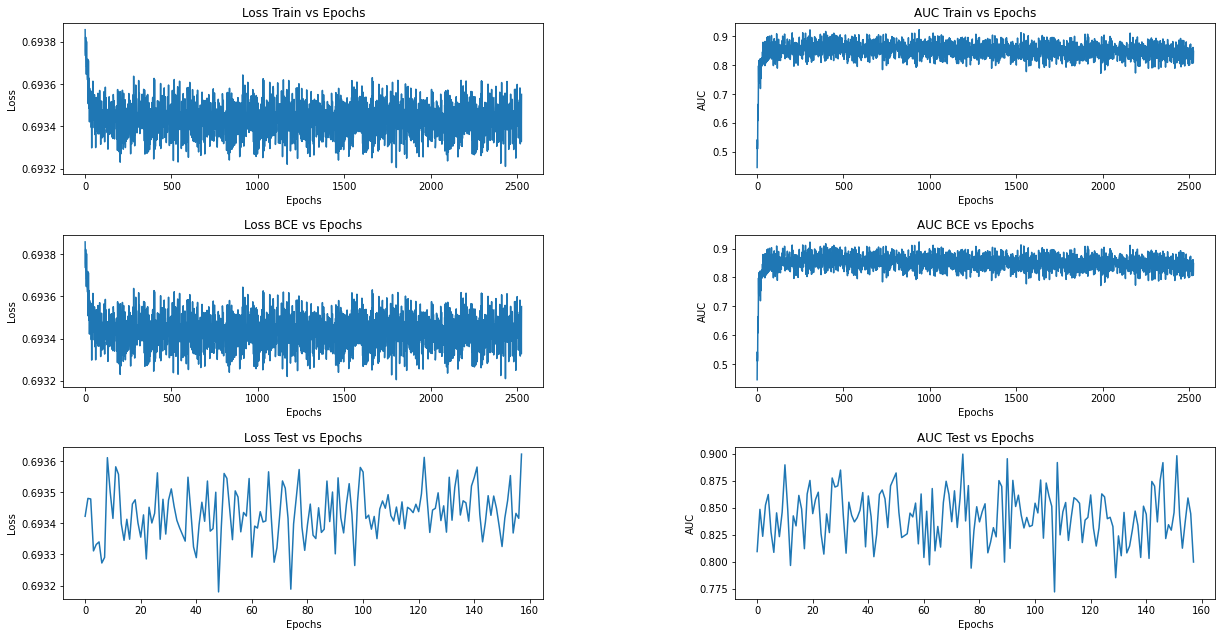

<Figure size 1600x800 with 0 Axes>

In [4]:
print_scores(l_loss, l_roc_train, l_loss, l_roc_train, l_roc_test, l_loss_test)